In [1]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import laplace
import random
import logging

2025-05-25 11:10:01.940014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748171402.156532      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748171402.222596      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Suppress TF logs
logging.getLogger("absl").setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# ------------------------ Utility Functions ------------------------ #
def blur_score(img):
    gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def color_heuristic(img):
    mean_colors = np.mean(img, axis=(0, 1))
    red, green, blue = mean_colors
    white = np.mean(mean_colors)
    
    color_std = np.std(img.reshape(-1, 3), axis=0)
    mixed_color_flag = np.mean(color_std) > 0.18

    high_blue = blue > 0.45 and blue > red and blue > green
    high_contrast = white < 0.12 or white > 0.92

    return int(high_blue or mixed_color_flag or high_contrast)

def load_images(folder, img_size=(224, 224)):
    images, names, blur_vals, color_flags = [], [], [], []
    for fname in sorted(os.listdir(folder)):
        try:
            path = os.path.join(folder, fname)
            img = cv2.imread(path)
            if img is not None:
                img = cv2.resize(img, img_size)
                norm = img.astype(np.float32) / 255.0
                images.append(norm)
                names.append(fname)
                blur_vals.append(blur_score(norm))
                color_flags.append(color_heuristic(norm))
        except:
            continue
    return np.array(images), names, np.array(blur_vals), np.array(color_flags)

In [3]:
# ------------------------ Load Data ------------------------ #
train_path = "/kaggle/input/soil-classification-part-2/soil_competition-2025/train"
test_path = "/kaggle/input/soil-classification-part-2/soil_competition-2025/test"
test_ids_path = "/kaggle/input/soil-classification-part-2/soil_competition-2025/test_ids.csv"

X_train_raw, _, _, _ = load_images(train_path)
X_test, test_names, test_blurs, test_colors = load_images(test_path)

# Augment soil dataset
augmenter = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.85, 1.15])

augmented = [augmenter.random_transform(img) for img in X_train_raw]
X_combined = np.concatenate([X_train_raw, np.array(augmented)])
X_train, X_val = train_test_split(X_combined, test_size=0.1, random_state=42)

# ------------------------ Autoencoder ------------------------ #
def build_autoencoder():
    input_layer = layers.Input(shape=(224, 224, 3))
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    encoded = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

    x = layers.UpSampling2D()(encoded)
    x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    decoded = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_layer, decoded)
    encoder = models.Model(input_layer, encoded)

    def hybrid_loss(y_true, y_pred):
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
        return mse + 0.6 * ssim

    autoencoder.compile(optimizer='adam', loss=hybrid_loss)
    return autoencoder, encoder

autoencoder, encoder = build_autoencoder()

I0000 00:00:1748171459.820715      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748171459.821448      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
# ------------------------ Training ------------------------ #
early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_reduce = callbacks.ReduceLROnPlateau(factor=0.5, patience=4)

autoencoder.fit(X_train, X_train,
                validation_data=(X_val, X_val),
                epochs=100,
                batch_size=64,
                callbacks=[early_stop, lr_reduce],
                verbose=1)

# ------------------------ Feature Extraction ------------------------ #
train_feats = encoder.predict(X_train_raw)
train_feats_flat = train_feats.reshape(len(train_feats), -1)

test_feats = encoder.predict(X_test)
test_feats_flat = test_feats.reshape(len(test_feats), -1)

# ------------------------ Isolation Forest ------------------------ #
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(train_feats_flat)
iso_preds = iso_forest.predict(test_feats_flat)
iso_preds = (iso_preds == 1).astype(int)

# ------------------------ Final Classification Heuristics ------------------------ #
# Combine blur and color-based heuristic override
blur_threshold = np.percentile(test_blurs, 35)
heuristic_flags = ((test_blurs < blur_threshold) | (test_colors == 1)).astype(int)

# Override predictions where heuristic_flags = 1
final_preds = np.where(heuristic_flags == 1, 0, iso_preds)

Epoch 1/100


I0000 00:00:1748171472.519064      61 service.cc:148] XLA service 0x7f7d5420f270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748171472.520165      61 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748171472.520189      61 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1748171472.799937      61 assert_op.cc:38] Ignoring Assert operator compile_loss/hybrid_loss/SSIM/Assert/Assert
W0000 00:00:1748171472.800044      61 assert_op.cc:38] Ignoring Assert operator compile_loss/hybrid_loss/SSIM/Assert_1/Assert
W0000 00:00:1748171472.800649      61 assert_op.cc:38] Ignoring Assert operator compile_loss/hybrid_loss/SSIM/Assert_2/Assert
W0000 00:00:1748171472.800796      61 assert_op.cc:38] Ignoring Assert operator compile_loss/hybrid_loss/SSIM/Assert_3/Assert
I0000 00:00:1748171472.984407      61 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:174

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 0.5154

W0000 00:00:1748171506.203578      60 assert_op.cc:38] Ignoring Assert operator compile_loss/hybrid_loss/SSIM/Assert/Assert
W0000 00:00:1748171506.203642      60 assert_op.cc:38] Ignoring Assert operator compile_loss/hybrid_loss/SSIM/Assert_1/Assert
W0000 00:00:1748171506.203687      60 assert_op.cc:38] Ignoring Assert operator compile_loss/hybrid_loss/SSIM/Assert_2/Assert
W0000 00:00:1748171506.203706      60 assert_op.cc:38] Ignoring Assert operator compile_loss/hybrid_loss/SSIM/Assert_3/Assert


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - loss: 0.5109

W0000 00:00:1748171518.181425      60 assert_op.cc:38] Ignoring Assert operator compile_loss/hybrid_loss/SSIM/Assert/Assert
W0000 00:00:1748171518.181561      60 assert_op.cc:38] Ignoring Assert operator compile_loss/hybrid_loss/SSIM/Assert_1/Assert
W0000 00:00:1748171518.181769      60 assert_op.cc:38] Ignoring Assert operator compile_loss/hybrid_loss/SSIM/Assert_2/Assert
W0000 00:00:1748171518.182298      60 assert_op.cc:38] Ignoring Assert operator compile_loss/hybrid_loss/SSIM/Assert_3/Assert
W0000 00:00:1748171521.148983      62 assert_op.cc:38] Ignoring Assert operator compile_loss/hybrid_loss/SSIM/Assert/Assert
W0000 00:00:1748171521.149047      62 assert_op.cc:38] Ignoring Assert operator compile_loss/hybrid_loss/SSIM/Assert_1/Assert
W0000 00:00:1748171521.149096      62 assert_op.cc:38] Ignoring Assert operator compile_loss/hybrid_loss/SSIM/Assert_2/Assert
W0000 00:00:1748171521.149107      62 assert_op.cc:38] Ignoring Assert operator compile_loss/hybrid_loss/SSIM/Assert_3/Ass

35/35 ━━━━━━━━━━━━━━━━━━━━ 60s 896ms/step - loss: 0.5066 - val_loss: 0.2113 - learning_rate: 0.0010
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - loss: 0.2237 - val_loss: 0.1933 - learning_rate: 0.0010
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 291ms/step - loss: 0.1931 - val_loss: 0.1771 - learning_rate: 0.0010
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms/step - loss: 0.1913 - val_loss: 0.1676 - learning_rate: 0.0010
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms/step - loss: 0.1728 - val_loss: 0.1608 - learning_rate: 0.0010
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step - loss: 0.1718 - val_loss: 0.1554 - learning_rate: 0.0010
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 294ms/step - loss: 0.1682 - val_loss: 0.1545 - learning_rate: 0.0010
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 297ms/step - loss: 0.1601 - val_loss: 0.1491 - learning_rate: 0.0010
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 296ms/step - loss: 0.1642 - val_loss: 0.1462 - learning_rate: 0.0010
Epoc

In [5]:
# ------------------------ Prediction Summary ------------------------ #
print("\nPrediction Summary:")
print(f"Soil: {np.sum(final_preds==1)}")
print(f"Non-Soil: {np.sum(final_preds==0)}")

# ------------------------ Submission ------------------------ #
test_ids_df = pd.read_csv(test_ids_path)
filename_to_pred = dict(zip(test_names, final_preds))
submission = pd.DataFrame({
    'image_id': test_ids_df['image_id'],
    'label': [filename_to_pred.get(i, 0) for i in test_ids_df['image_id']]
})
submission.to_csv("submission.csv", index=False)
print("submission.csv written.")


Prediction Summary:
Soil: 112
Non-Soil: 855
submission.csv written.


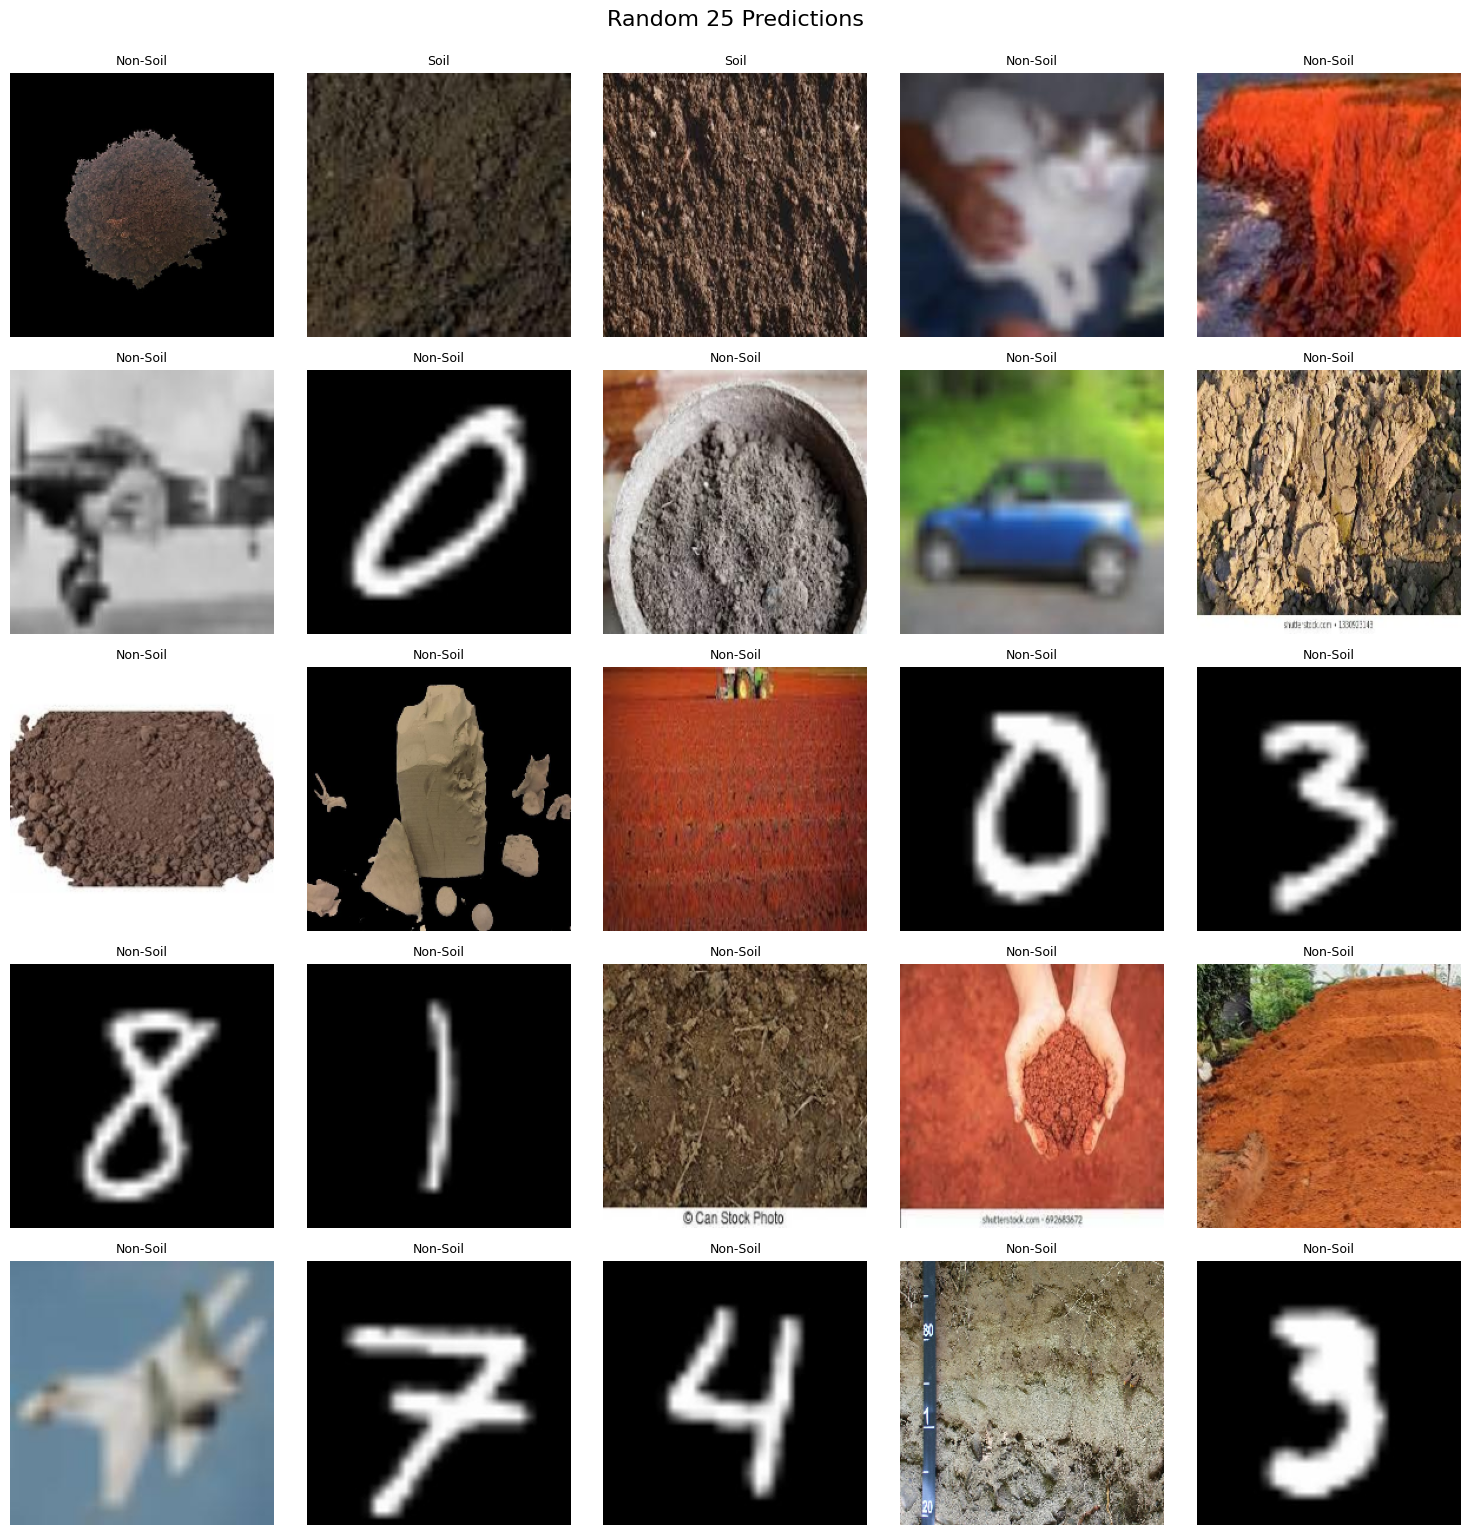

In [6]:
# ------------------------ Visualization ------------------------ #
plt.figure(figsize=(15, 15))
idxs = random.sample(range(len(X_test)), 25)
for i, idx in enumerate(idxs):
    plt.subplot(5, 5, i + 1)
    img = (X_test[idx] * 255).astype(np.uint8)
    label = 'Soil' if final_preds[idx] == 1 else 'Non-Soil'
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(label, fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Random 25 Predictions", y=1.02, fontsize=16)
plt.show()